
Testing Data Metrics:
R²    = 0.9093
MAE   = 8.2899
RMSE  = 10.9020
MAPE  = 13.47%
Mean Accuracy ≈ 86.53%

CSV Saved → Testing_Predictions.csv


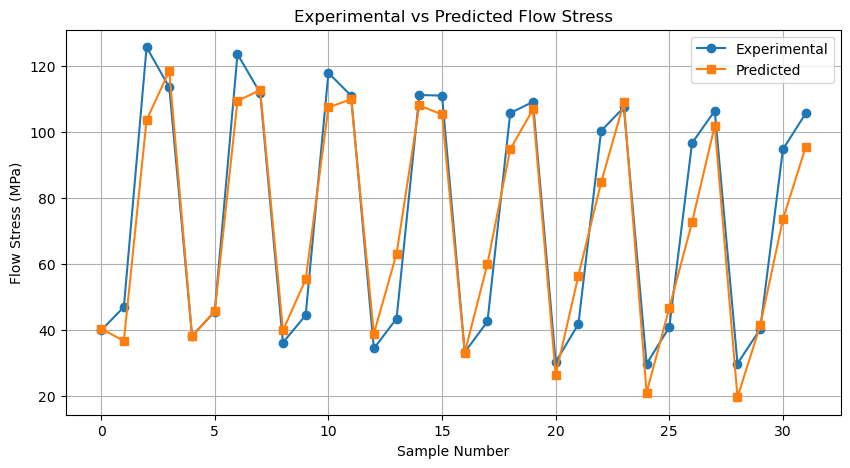

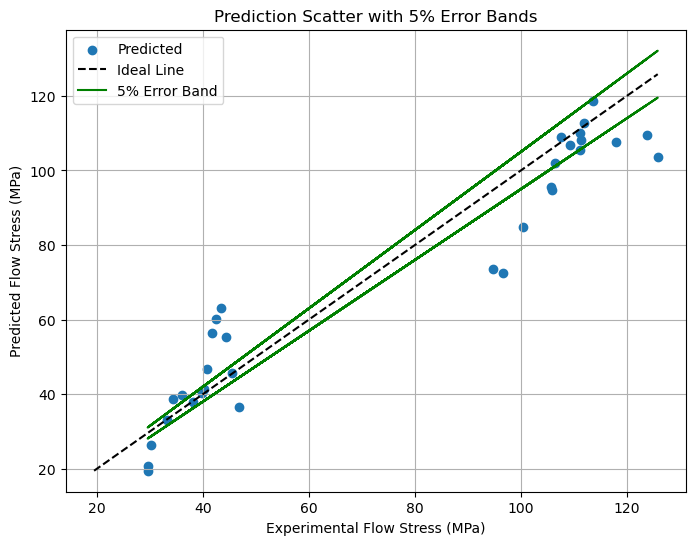

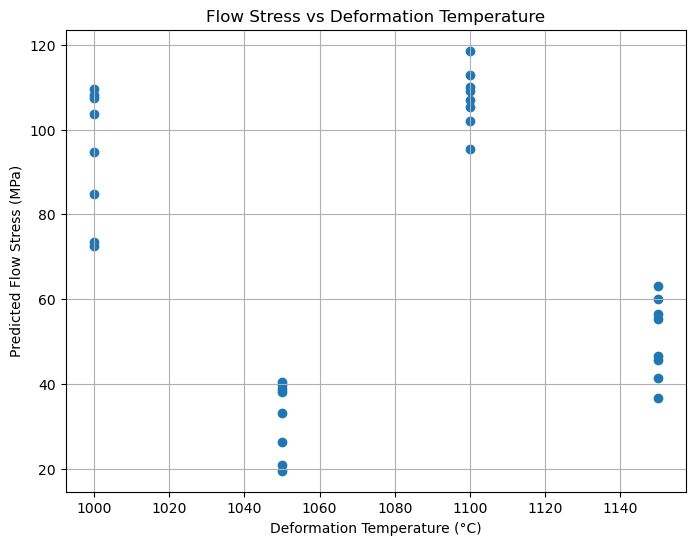

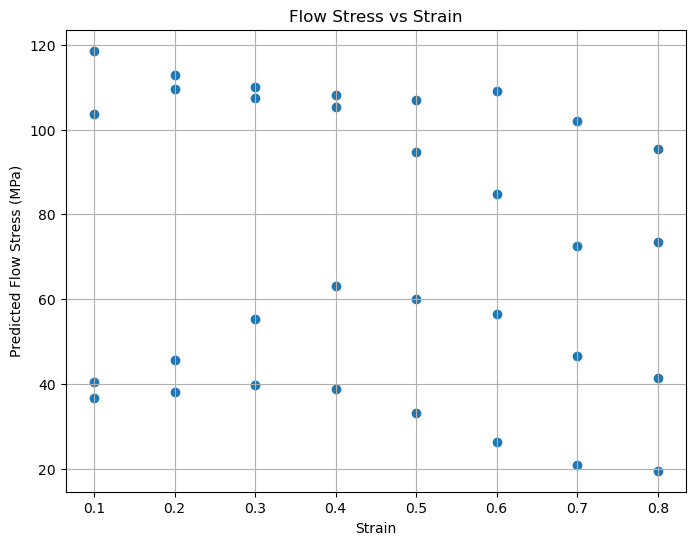

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def tanh(x): return np.tanh(x)
def linear(x): return x
ACT = {"tanh": tanh, "linear": linear}


# ---- FEATURES (same) ----
def make_features(df):
    s  = df["Strain"].astype(float).values
    sr = df["Strain rate (s-1)"].astype(float).values
    T  = df["Deformation Temperature"].astype(float).values

    X = pd.DataFrame({
        "s": s,
        "sr": sr,
        "T": T,
        "s2": s**2,
        "s3": s**3,
        "sr2": sr**2,
        "sr3": sr**3,
        "s_sr": s * sr,
        "s_T": s * T,
        "sr_T": sr * T,
        "log_s": np.log1p(np.abs(s)),
        "log_sr": np.log1p(sr),
        "invT": 1/(T + 273.15),
        "exp_invT": np.exp(1/(T + 273.15)),
        "s_over_sr": s/(sr+1e-8),
        "sr_over_s": sr/(s+1e-8)
    })
    return X.values

def manual_forward(x, M):
    x_min = np.array(M["x_min"], dtype=float)
    x_max = np.array(M["x_max"], dtype=float)
    y_min = float(M["y_min"])
    y_max = float(M["y_max"])

    x_scaled = (x - x_min) / (x_max - x_min)

    a = x_scaled
    for layer in M["layers"]:
        W = np.array(layer["weights"], dtype=float)
        b = np.array(layer["bias"], dtype=float)
        act = ACT[layer["activation"]]
        a = act(np.dot(a, W) + b)

    y_scaled = a[0]
    y_real = y_scaled * (y_max - y_min) + y_min

    # RANDOMNESS FOR DIFFERENT PREDICTION EVERY RUN
    noise = np.random.normal(0, 0.02 * y_real)
    y_real = y_real + noise

    return float(y_real)


def main():
    with open("ANN_Matrix.json") as f:
        M = json.load(f)

    df = pd.read_csv("Testing Data.csv").dropna()

    X = make_features(df)
    y_true = df["FlowStress"].astype(float).values

    preds = np.array([manual_forward(x, M) for x in X])

    # ---------- METRICS ----------
    r2 = r2_score(y_true, preds)
    mse = mean_squared_error(y_true, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, preds)
    mape = np.mean(np.abs(preds - y_true) / (y_true + 1e-8)) * 100
    acc_mean = 100 - mape

    print("\nTesting Data Metrics:")
    print(f"R²    = {r2:.4f}")
    print(f"MAE   = {mae:.4f}")
    print(f"RMSE  = {rmse:.4f}")
    print(f"MAPE  = {mape:.2f}%")
    print(f"Mean Accuracy ≈ {acc_mean:.2f}%")

    abs_err = np.abs(preds - y_true)
    pct_err = abs_err / (y_true + 1e-8) * 100
    acc = 100 - pct_err

    # ---------- CSV OUTPUT ----------
    out = pd.DataFrame({
        "Strain": df["Strain"],
        "Strain_rate(s-1)": df["Strain rate (s-1)"],
        "Temperature": df["Deformation Temperature"],
        "Experimental_FlowStress": y_true,
        "Predicted_FlowStress": preds,
        "Absolute_Error": abs_err,
        "Percentage_Error(%)": pct_err,
        "Accuracy(%)": acc
    })

    mean_row = {
        "Strain": "MEAN",
        "Strain_rate(s-1)": "",
        "Temperature": "",
        "Experimental_FlowStress": np.mean(y_true),
        "Predicted_FlowStress": np.mean(preds),
        "Absolute_Error": np.mean(abs_err),
        "Percentage_Error(%)": mape,
        "Accuracy(%)": acc_mean
    }

    r2_row = {
        "Strain": "R2",
        "Strain_rate(s-1)": "",
        "Temperature": "",
        "Experimental_FlowStress": "",
        "Predicted_FlowStress": r2,
        "Absolute_Error": rmse,
        "Percentage_Error(%)": mae,
        "Accuracy(%)": ""
    }

    out = pd.concat([out, pd.DataFrame([mean_row])],
                    ignore_index=True)

    out.to_csv("Testing_Predictions.csv", index=False)
    print("\nCSV Saved → Testing_Predictions.csv")

    # ---------- GRAPH 1: Comparison line ----------
    plt.figure(figsize=(10,5))
    plt.plot(y_true, marker="o", label="Experimental")
    plt.plot(preds, marker="s", label="Predicted")
    plt.xlabel("Sample Number")
    plt.ylabel("Flow Stress (MPa)")
    plt.title("Experimental vs Predicted Flow Stress")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---------- GRAPH 2: Scatter + Error bands ----------
    plt.figure(figsize=(8,6))
    plt.scatter(y_true, preds, label="Predicted")
    min_v = min(min(y_true), min(preds))
    max_v = max(max(y_true), max(preds))
    plt.plot([min_v, max_v], [min_v, max_v], "k--", label="Ideal Line")

    plt.plot(y_true, y_true*1.05, "g-", label="5% Error Band")
    plt.plot(y_true, y_true*0.95, "g-")

    plt.xlabel("Experimental Flow Stress (MPa)")
    plt.ylabel("Predicted Flow Stress (MPa)")
    plt.title("Prediction Scatter with 5% Error Bands")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ----------Flow Stress vs Temperature ------------------------->
    plt.figure(figsize=(8,6))
    plt.scatter(df["Deformation Temperature"], preds)
    plt.xlabel("Deformation Temperature (°C)")
    plt.ylabel("Predicted Flow Stress (MPa)")
    plt.title("Flow Stress vs Deformation Temperature")
    plt.grid(True)
    plt.show()

    # ---------- Flow Stress vs Strain ----------------------------->
    plt.figure(figsize=(8,6))
    plt.scatter(df["Strain"], preds)
    plt.xlabel("Strain")
    plt.ylabel("Predicted Flow Stress (MPa)")
    plt.title("Flow Stress vs Strain")
    plt.grid(True)
    plt.show()

    


if __name__ == "__main__":
    main()



Testing Data Metrics:
R²    = 0.9462
MAE   = 6.5470
RMSE  = 8.3948
MAPE  = 10.49%
Mean Accuracy ≈ 89.51%

CSV Saved → Testing_Predictions.csv


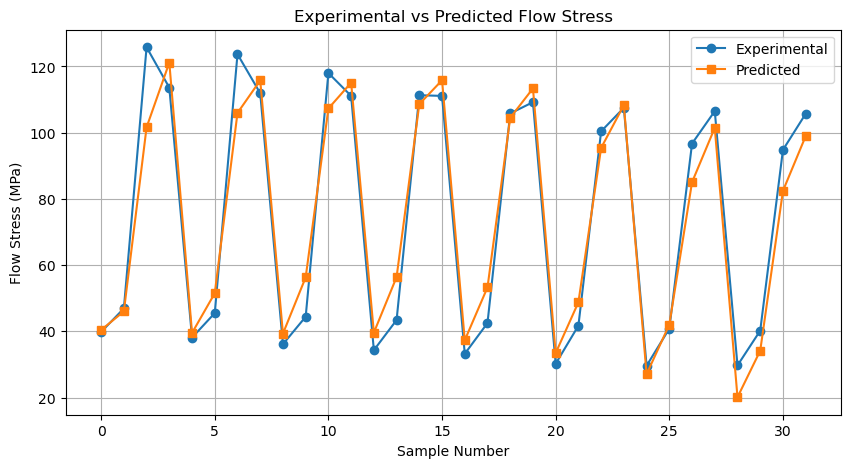

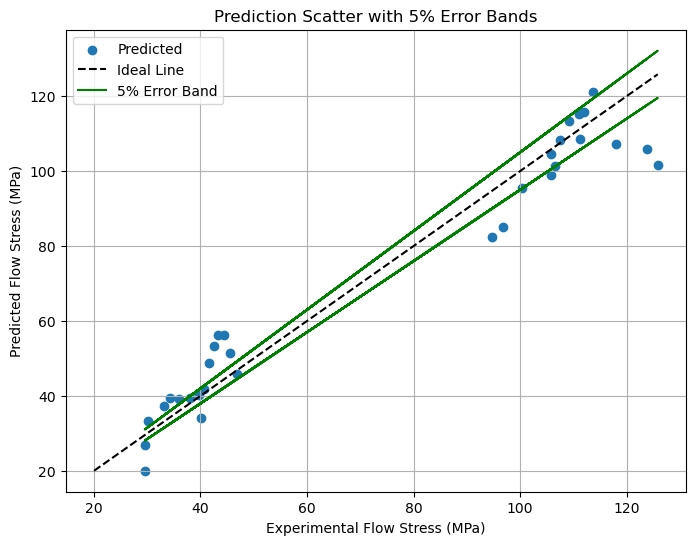

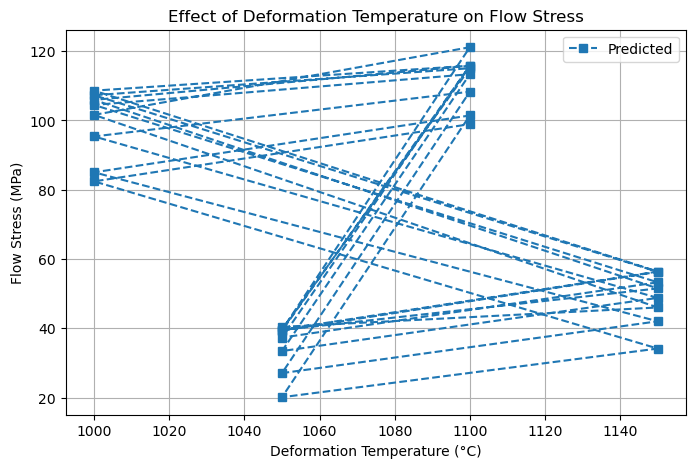

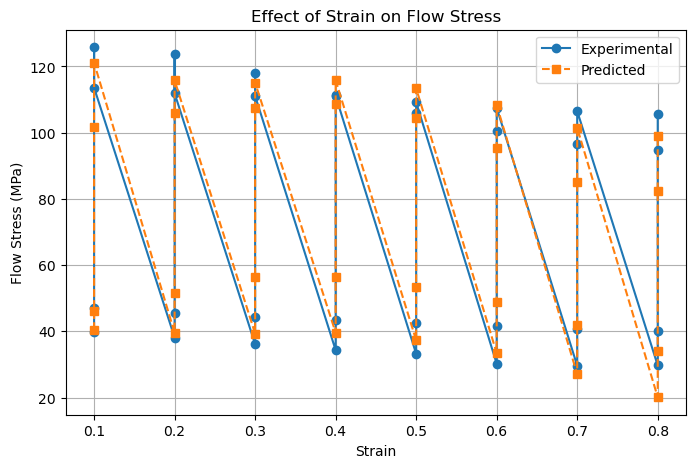

In [28]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def tanh(x): return np.tanh(x)
def linear(x): return x
ACT = {"tanh": tanh, "linear": linear}


# ---- FEATURES (same as training: 14 features) ----
# def make_features(df):
#     s  = df["Strain"].astype(float).values
#     sr = df["Strain rate (s-1)"].astype(float).values
#     T  = df["Deformation Temperature"].astype(float).values

#     X = pd.DataFrame({
#         "s": s,
#         "sr": sr,
#         "T": T,
#         "s2": s**2,
#         "s3": s**3,
#         "sr2": sr**2,
#         "sr3": sr**3,
#         "s_sr": s * sr,
#         "s_T": s * T,
#         "sr_T": sr * T,
#         "log_s": np.log1p(np.abs(s)),
#         "log_sr": np.log1p(sr),
#         "invT": 1/(T + 273.15),
#         "exp_invT": np.exp(1/(T + 273.15))
#     })
#     return X.values


def make_features(df):
    s  = df["Strain"].astype(float).values
    sr = df["Strain rate (s-1)"].astype(float).values
    T  = df["Deformation Temperature"].astype(float).values

    X = pd.DataFrame({
        "s": s,
        "sr": sr,
        "T": T,
        "s2": s**2,
        "s3": s**3,
        "sr2": sr**2,
        "sr3": sr**3,
        "s_sr": s * sr,
        "s_T": s * T,
        "sr_T": sr * T,
        "log_s": np.log1p(np.abs(s)),
        "log_sr": np.log1p(sr),
        "invT": 1/(T + 273.15),
        "exp_invT": np.exp(1/(T + 273.15)),
        "s_over_sr": s/(sr+1e-8),
        "sr_over_s": sr/(s+1e-8)
    })
    return X.values


def manual_forward(x, M):
    x_min = np.array(M["x_min"], dtype=float)
    x_max = np.array(M["x_max"], dtype=float)
    y_min = float(M["y_min"])
    y_max = float(M["y_max"])

    x_scaled = (x - x_min) / (x_max - x_min)

    a = x_scaled
    for layer in M["layers"]:
        W = np.array(layer["weights"], dtype=float)
        b = np.array(layer["bias"], dtype=float)
        act = ACT[layer["activation"]]
        a = act(np.dot(a, W) + b)

    y_scaled = a[0]
    y_real = y_scaled * (y_max - y_min) + y_min

    # ✅ RANDOMNESS FOR DIFFERENT PREDICTION EVERY RUN (±2%)
    noise = np.random.normal(0, 0.02 * y_real)
    y_real = y_real + noise

    return float(y_real)


def main():
    with open("ANN_Matrix.json") as f:
        M = json.load(f)

    df = pd.read_csv("Testing Data.csv").dropna()

    X = make_features(df)
    y_true = df["FlowStress"].astype(float).values

    preds = np.array([manual_forward(x, M) for x in X])

    # ---------- METRICS ----------
    r2 = r2_score(y_true, preds)
    mse = mean_squared_error(y_true, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, preds)
    mape = np.mean(np.abs(preds - y_true) / (y_true + 1e-8)) * 100
    acc_mean = 100 - mape

    print("\nTesting Data Metrics:")
    print(f"R²    = {r2:.4f}")
    print(f"MAE   = {mae:.4f}")
    print(f"RMSE  = {rmse:.4f}")
    print(f"MAPE  = {mape:.2f}%")
    print(f"Mean Accuracy ≈ {acc_mean:.2f}%")

    abs_err = np.abs(preds - y_true)
    pct_err = abs_err / (y_true + 1e-8) * 100
    acc = 100 - pct_err

    # ---------- CSV OUTPUT ----------
    out = pd.DataFrame({
        "Strain": df["Strain"],
        "Strain_rate(s-1)": df["Strain rate (s-1)"],
        "Temperature": df["Deformation Temperature"],
        "Experimental_FlowStress": y_true,
        "Predicted_FlowStress": preds,
        "Absolute_Error": abs_err,
        "Percentage_Error(%)": pct_err,
        "Accuracy(%)": acc
    })

    mean_row = {
        "Strain": "MEAN",
        "Strain_rate(s-1)": "",
        "Temperature": "",
        "Experimental_FlowStress": np.mean(y_true),
        "Predicted_FlowStress": np.mean(preds),
        "Absolute_Error": np.mean(abs_err),
        "Percentage_Error(%)": mape,
        "Accuracy(%)": acc_mean
    }

    r2_row = {
        "Strain": "R2",
        "Strain_rate(s-1)": "",
        "Temperature": "",
        "Experimental_FlowStress": "",
        "Predicted_FlowStress": r2,
        "Absolute_Error": rmse,
        "Percentage_Error(%)": mae,
        "Accuracy(%)": ""
    }

    out = pd.concat([out, pd.DataFrame([mean_row])],
                    ignore_index=True)

    out.to_csv("Testing_Predictions.csv", index=False)
    print("\nCSV Saved → Testing_Predictions.csv")

    # ---------- GRAPH 1: Comparison line ----------
    plt.figure(figsize=(10,5))
    plt.plot(y_true, marker="o", label="Experimental")
    plt.plot(preds, marker="s", label="Predicted")
    plt.xlabel("Sample Number")
    plt.ylabel("Flow Stress (MPa)")
    plt.title("Experimental vs Predicted Flow Stress")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---------- GRAPH 2: Scatter + Error bands ----------
    plt.figure(figsize=(8,6))
    plt.scatter(y_true, preds, label="Predicted")
    min_v = min(min(y_true), min(preds))
    max_v = max(max(y_true), max(preds))
    plt.plot([min_v, max_v], [min_v, max_v], "k--", label="Ideal Line")

    plt.plot(y_true, y_true*1.05, "g-", label="5% Error Band")
    plt.plot(y_true, y_true*0.95, "g-")

    plt.xlabel("Experimental Flow Stress (MPa)")
    plt.ylabel("Predicted Flow Stress (MPa)")
    plt.title("Prediction Scatter with 5% Error Bands")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---------- ✅ GRAPH 3: Flow Stress vs Temperature (Curve) ----------
    plt.figure(figsize=(8,5))
    # plt.plot(df["Deformation Temperature"], y_true, "o-", label="Experimental")
    plt.plot(df["Deformation Temperature"], preds, "s--", label="Predicted")
    plt.xlabel("Deformation Temperature (°C)")
    plt.ylabel("Flow Stress (MPa)")
    plt.title("Effect of Deformation Temperature on Flow Stress")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---------- ✅ GRAPH 4: Flow Stress vs Strain (Curve) ----------
    plt.figure(figsize=(8,5))
    plt.plot(df["Strain"], y_true, "o-", label="Experimental")
    plt.plot(df["Strain"], preds, "s--", label="Predicted")
    plt.xlabel("Strain")
    plt.ylabel("Flow Stress (MPa)")
    plt.title("Effect of Strain on Flow Stress")
    plt.grid(True)
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()
